<a href="https://colab.research.google.com/github/nadduck/dnd-ml/blob/master/D%26D_Character_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Map

In [ ]:
# steps

# get our data
    # pull the data
    # transform the data
    # recombine the data
    # get level column
    # remove any multiclass observations for now
    # remove artificer (not established data)
    # determine how to handle casting stat (categorical var) -- turn into six binary columns for each stat
    # initial simple data set will be: stats, hp, level, ac, casting stat

# EDA (exploratory data analysis)
    # distributions
    # descriptive stats
    # correlations
    # identify data issues (class labeling--complexity around structure and multiclassing, high dimensionality)
    # outlier handling -- TO DO: 
    # is the data balanced or imbalanced

# plan the model
    # identify key accuracy metrics
        # sensitivity / specificity / recall
        # true positive rate /false positive rate / f1 score, etc. 
        # confusion matrix
    # what is your success criteria?
        # what 'accuracy' do i need to achieve the ask
        # what are my constraints if any

# first pass modeling
    # really simple models
        # logistic regression
        # decision tree
        # benchmark accuracy
        
# more complex modeling
    # ensemble (random forest)
    # boosting (xgboost, adaboost)
    # feature selection (information gain, recursive feature elmination)

# model selection
    # what model best achieves our goals

# Preamble

In [ ]:
# going to explore some Dungeons and Dragons character data from : https://github.com/oganm/dnddata#about-the-data
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder

# Getting data

## Pull data

In [ ]:
# get the data from the github repository
url = "https://raw.githubusercontent.com/oganm/dnddata/master/data-raw/dnd_chars_all.json"

df = pd.read_json(url)

if df.shape[0] < df.shape[1]:
    df = df.transpose()

,ip,finger,name,race,background,date,class,level,levelGroup,feats,HP,AC,attributes,alignment,skills,weapons,spells,castingStat,choices,location,hash
optimistic_bhabha Fighter 8,[639f3bf],[d68edcb],"{'hash': ['0333386'], 'alias': ['optimistic_bh...","{'race': ['High Elf'], 'processedRace': ['Elf']}",[Soldier],[2020-07-11 19:44:27],"{'Fighter': {'class': ['Fighter'], 'subclass':...",[8],[8-11],[],[93],[19],"{'Str': [18], 'Dex': [18], 'Con': [16], 'Int':...","{'alignment': [''], 'processedAlignment': ['']...","[Athletics, Acrobatics, History, Perception, I...","{'Battleaxe': {'weapon': ['Battleaxe'], 'proce...",{},[Int],{'fighting style': ['Defense']},"{'country': ['United States'], 'countryCode': ...",[03027f98fee6211735d1ec38e2d7cb3c]
naughty_shtern Barbarian 1|Warlock 1,[245b1cd],[abc5a45],"{'hash': ['bdec192'], 'alias': ['naughty_shter...","{'race': ['Half-Orc'], 'processedRace': ['Half...",[Outlander],[2020-07-11 19:29:34],"{'Barbarian': {'class': ['Barbarian'], 'subcla...",[2],[1-3],[],[16],[15],"{'Str': [18], 'Dex': [13], 'Con': [16], 'Int':...","{'alignment': ['Chaotic Neutral'], 'processedA...","[Athletics, Nature, Perception, Survival, Inti...","{'Greatclub': {'weapon': ['Greatclub'], 'proce...",{'Green Flame Blade*0': {'spell': ['Green Flam...,[Cha],{},"{'country': ['United States'], 'countryCode': ...",[2959a8c8a3e73643b456a1f3200334e7]
optimistic_bhabha Barbarian 6,[639f3bf],[d68edcb],"{'hash': ['0333386'], 'alias': ['optimistic_bh...","{'race': ['High Elf'], 'processedRace': ['Elf']}",[Soldier],[2020-07-11 18:57:41],"{'Barbarian': {'class': ['Barbarian'], 'subcla...",[6],[4-7],[],[73],[15],"{'Str': [19], 'Dex': [17], 'Con': [15], 'Int':...","{'alignment': [''], 'processedAlignment': ['']...","[Athletics, Nature, Perception, Survival, Inti...","{'Greataxe': {'weapon': ['Greataxe'], 'process...",{},[Int],{},"{'country': ['United States'], 'countryCode': ...",[0108cfbdfbde73e2178ac0eeadb66c5c]
amazing_wiles Paladin 12,[],[d63ad02],"{'hash': ['a6dd425'], 'alias': ['amazing_wiles']}","{'race': ['Mountain Dwarf'], 'processedRace': ...",[Acolyte],[2020-07-11 17:40:57],"{'Paladin': {'class': ['Paladin'], 'subclass':...",[12],[12-15],[Heavy Armor Master],[176],[21],"{'Str': [16], 'Dex': [8], 'Con': [20], 'Int': ...","{'alignment': [''], 'processedAlignment': ['']...","[Athletics, Religion, Insight, Persuasion]","{'Warhammer': {'weapon': ['Warhammer'], 'proce...",{'Armor of Frost*1': {'spell': ['Armor of Fros...,[Cha],{'fighting style': ['Defense']},"{'country': ['Canada'], 'countryCode': ['CA']}",[11a689cf2f902f22882792ceec101f46]
keen_lovelace Warlock 7,[1ba21f0],[71bc98c],"{'hash': ['9c85006'], 'alias': ['keen_lovelace']}","{'race': ['Half-Elf'], 'processedRace': ['Half...",[Folk Hero],[2020-07-11 15:14:16],"{'Warlock': {'class': ['Warlock'], 'subclass':...",[7],[4-7],[War Caster],[52],[11],"{'Str': [13], 'Dex': [8], 'Con': [15], 'Int': ...","{'alignment': ['Chaotic Good'], 'processedAlig...","[Arcana, History, Animal Handling, Perception,...","{'Crossbow, light': {'weapon': ['Crossbow, lig...",{},[Cha],"{'pact boon': ['Pact of the Blade'], 'eldritch...","{'country': ['United States'], 'countryCode': ...",[31bc0dd883d16e40cc596a9fdbf0472f]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nervous_goldstine Ranger 3,[d580ce9],[d580ce9],"{'hash': ['cf1fa28'], 'alias': ['nervous_golds...","{'race': ['Half-Elf'], 'processedRace': ['Half...",[Mercenary Veteran],[2018-04-07 08:40:55],"{'Ranger': {'class': ['Ranger'], 'subclass': [...",[3],[1-3],[],[32],[16],"{'Str': [10], 'Dex': [16], 'Con': [14], 'Int':...","{'alignment': [''], 'processedAlignment': ['']...","[Athletics, Stealth, Animal Handling, Insight,...","{'Shortsword': {'weapon': ['Shortsword'], 'pro...",{},[Wis],{'fighting style': ['Archery']},"{'country': [None], 'countryCode': [None]}",[05998a5e27f3b8f14b58644ca9a10d42]
gallant_hugle Druid 2|Bard 2,[d580ce9],[d580ce9],"{'hash': ['923bffb'], 'alias': ['gallant_hugle']}","{'race': ['

## Unpack data

In [ ]:
# unpacking everything each column comes in 2 types: jsons or singleton lists
# but dtypes only indicate if it's a python 'object' 
# drop some of the unnecessary (for us) columns, e.g. ip, finger, date, location, hash, choices
# [7803 rows x 11457 columns] for spells, drop those and weapons for now

ignore = ['ip', 'finger','date', 'location', 'hash', 'choices','weapons', 'name', 'spells']

clean_df = pd.json_normalize(df['name'])
clean_df = clean_df['alias'].str[0]

for key in df.keys():
  if key in ignore:
    continue
  try: # try doing a json_normalize, which will fail if it's not a json
    data = pd.json_normalize(df[key])
    for col in data.keys(): # unpack the singletons in each json column
      data[col] = data[col].str[0]
  except AttributeError: 
    data = df[key].str[0]
    data = data.reset_index(drop=True) # use integer index to conform with json_normalize index
  
  clean_df = pd.concat([clean_df, data], axis=1)

num_spells = df['spells'].apply(len).reset_index(drop=True)

clean_df = pd.concat([clean_df, num_spells], axis = 1)

clean_df['spells']

0       0
1       4
2       0
3       6
4       0
       ..
7927    0
7928    0
7929    7
7930    7
7931    0
Name: spells, Length: 7932, dtype: int64

## Add features

In [ ]:
# add generic "primary class" column/label
class_list = ['Artificer.level','Barbarian.level','Bard.level','Cleric.level','Druid.level','Fighter.level','Monk.level' \
                  ,'Paladin.level','Ranger.level','Rogue.level','Sorcerer.level','Warlock.level','Wizard.level']
class_df = clean_df[class_list]

primary_class = class_df.idxmax(axis=1)
class1 = list(primary_class.str.split('.').str[0])
clean_df['class1'] = class1

# add generic "primary class level" column/label
primary_class_level = class_df.max(axis=1)
clean_df['level1'] = primary_class_level

# add binary casting<Stat> for each attribute
attributes = ['Cha','Con','Dex','Int','Str','Wis']

for attribute in attributes:
  castingStat = clean_df['castingStat'] == attribute
  clean_df[f'casting{attribute}'] = castingStat.astype(int)

clean_df['spells']


0       0
1       4
2       0
3       6
4       0
       ..
7927    0
7928    0
7929    7
7930    7
7931    0
Name: spells, Length: 7932, dtype: int64

## Clean and filter data

In [ ]:
# remove multi-classes
num_classes = clean_df[class_list].apply(lambda x: x.count(), axis=1)
print('removing', len(clean_df[num_classes != 1]), 'multi-class (or zero class) entries')
no_multi_df = clean_df[num_classes == 1]

removing 969 multi-class (or zero class) entries


In [ ]:
# remove artificer class
print('removing', len(no_multi_df[no_multi_df['Artificer.level'].notnull()]), 'Artificer entries')
no_artificer_df = no_multi_df[~no_multi_df['Artificer.level'].notnull()]

removing 60 Artificer entries


In [ ]:
# clean up further by removing redundant columns (with new class1 and level1 labels)
keep = ['alias',
        'race', 'processedRace', # probably only need one
        'background',
        'level','levelGroup', # do we need these
        'feats',
        'HP', 'AC',
        'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha',
        'processedAlignment',
        'skills', 
        'castingStat', 
        'class1','level1',
        'castingCha', 'castingCon', 'castingDex', 'castingInt',	'castingStr',	'castingWis',
        'spells']

no_artificer_df = no_artificer_df[keep]

removing 79 entries with HP / level < 2.5 and HP / level > 16.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


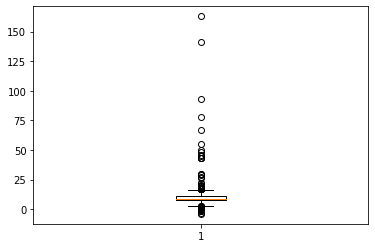

In [ ]:
# remove outliers in stat, hp, and ac following 1.5*iqr convention


if 0: # don't like this, retry with hp / level
  total_outliers = 0

  #for att in attributes + ['HP', 'AC']:
  for att in ['HP', 'AC'] + attributes:
    boxplot = plt.boxplot(no_artificer_df[att], labels=[att])
    whiskers = [x.get_ydata()[1] for x in boxplot['whiskers']] # gives the 1.5*iqr whisker boundaries

    n_small_outliers = len(no_artificer_df[no_artificer_df[att] < whiskers[0]])
    n_large_outliers = len(no_artificer_df[no_artificer_df[att] > whiskers[1]])
    n_outliers = n_small_outliers + n_large_outliers
    total_outliers += n_outliers

    print(f'removing {n_outliers} entries with {att} < {whiskers[0]} and {att} > {whiskers[1]}')
    no_artificer_df = no_artificer_df[no_artificer_df[att] >= whiskers[0]]
    no_artificer_df = no_artificer_df[no_artificer_df[att] <= whiskers[1]]

  print(f'removed {total_outliers} outliers in total')

# blindly following 1.5*iqr rule kills a lot, might need to revisit this and do something more nuanced
# the 1.5 scaling might be better suited to specific distributions (Gaussian), which the HP does not follow 
# in fact, the HP has a lot of 'outliers' by this metric, and in removing them, changes the iqr for distributions after
# so the final number of removed outliers is dependent on which order you perform it in, if using only the 1.5*iqr rule
# 6007 / 7803 remain if doing [attributes, 'HP', 'AC'] vs 6221 / 7803 if doing ['HP', 'AC', attributes]

hp_per_level = no_artificer_df['HP'].divide(no_artificer_df['level1'])

boxplot = plt.boxplot(hp_per_level)
whiskers = [x.get_ydata()[1] for x in boxplot['whiskers']] # gives the 1.5*iqr whisker boundaries

n_small_outliers = len(hp_per_level[hp_per_level < whiskers[0]])
n_large_outliers = len(hp_per_level[hp_per_level > whiskers[1]])
n_outliers = n_small_outliers + n_large_outliers

print(f'removing {n_outliers} entries with HP / level < {whiskers[0]} and HP / level > {whiskers[1]}')
no_artificer_df = no_artificer_df[hp_per_level >= whiskers[0]]
no_artificer_df = no_artificer_df[hp_per_level <= whiskers[1]]



In [ ]:
# set main_df as primary DataFrame for modeling (lol)
# didn't use clean_df because it broke some of the existing cells below
main_df = no_artificer_df
main_df.describe()

,level,HP,AC,Str,Dex,Con,Int,Wis,Cha,level1,castingCha,castingCon,castingDex,castingInt,castingStr,castingWis,spells
count,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000,6824.000000
mean,4.326641,39.144783,15.215563,12.808324,14.583382,14.282679,11.921893,13.121043,13.063013,4.321073,0.277403,0.001319,0.000879,0.471424,0.000879,0.248095,3.586899
std,3.719478,37.639984,2.516483,3.871323,3.011643,2.318407,2.915925,2.990385,3.523687,3.712667,0.447750,0.036295,0.029641,0.499219,0.029641,0.431939,6.644514
min,1.000000,3.000000,7.000000,1.000000,3.000000,4.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,13.000000,13.000000,10.000000,13.000000,13.000000,10.000000,11.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,15.000000,12.000000,15.000000,14.000000,12.000000,13.000000,13.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,49.000000,17.000000,16.000000,16.000000,16.000000,14.000000,15.000000,16.000000,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000
max,24.000000,303.000000,32.000000,30.000000,29.000000,30.000000,26.000000,46.000000,32.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98.000000


# Exploratory Data Analysis

## Number of multi-class

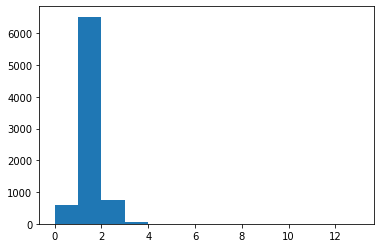

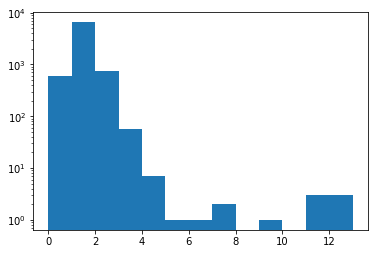

In [ ]:
clean_df[clean_df['race'] == 'Goblin']

clean_df[clean_df['Ranger.class'] == 'Ranger']

(clean_df['Ranger.class'] == 'Ranger') & (clean_df['race'] == 'Goblin')

clean_df[(clean_df['Ranger.class'] == 'Ranger') & (clean_df['race'] == 'Goblin')]

clean_df[(clean_df['Ranger.class'].notnull()) & (clean_df['Ranger.subclass'] != '')]

classes = ['Ranger.class', 
           'Barbarian.class', 
           'Bard.class', 
           'Druid.class', 
           'Paladin.class', 
           'Wizard.class',
           'Fighter.class',
           'Cleric.class',
           'Artificer.class',
           'Rogue.class',
           'Sorcerer.class',
           'Warlock.class']

clean_df[clean_df['alias'] == 'suspicious_goldwasser']

# there are characters with multiple <CLASS>.class entries

class_levels = [x.replace('class', 'level') for x in classes]

num_classes = clean_df[class_levels].apply(lambda x: x.count(), axis=1)

plt.hist(num_classes, bins=13, range=(0,13))
plt.show()

plt.hist(num_classes, bins=13, range=(0,13))
plt.yscale('log')
plt.show()

# fortunately it's predominantly only 1-class followed by 2-class, 
# a fair chunk of 0-class and a smattering of >2-class, should we just remove?

## Number of each class

<function matplotlib.pyplot.show>

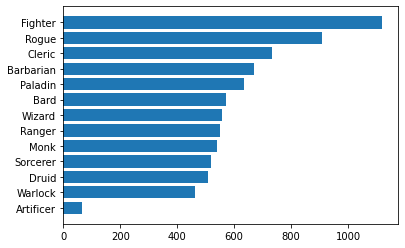

In [ ]:
# start simple, how many of each class
classes = clean_df.class1.value_counts().index
class_counts = clean_df.class1.value_counts().values

class_count_tuples = list( zip(classes, class_counts))

class_data = pd.DataFrame( class_count_tuples,
                              columns = ['class','counts'])

plt.barh(class_data['class'], class_data['counts'])
plt.gca().invert_yaxis()
plt.show

# what do we want to know
  # what does the class data look like (balanced? any nuances?)
    # how do we handle multiclassing?
    # how do we handle if equal levels in both classes?
    
  # what variables might be related / have information 
# level distribution
# race distribution
#hp
#ac
#casting stat

## Distributions

### Attribute distributions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


               Str          Dex  ...          Wis          Cha
count  7932.000000  7932.000000  ...  7932.000000  7932.000000
mean     12.830182    14.697176  ...    13.124685    13.152042
std       4.035092     3.230767  ...     3.164264     3.697465
min       1.000000     3.000000  ...     1.000000     0.000000
25%      10.000000    13.000000  ...    11.000000    10.000000
50%      12.000000    15.000000  ...    13.000000    13.000000
75%      16.000000    17.000000  ...    15.000000    16.000000
max     103.000000   101.000000  ...   100.000000    99.000000

[8 rows x 6 columns]


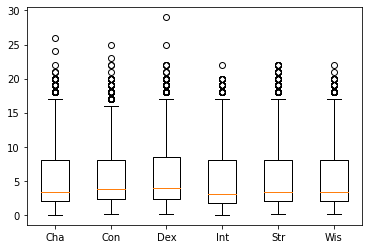

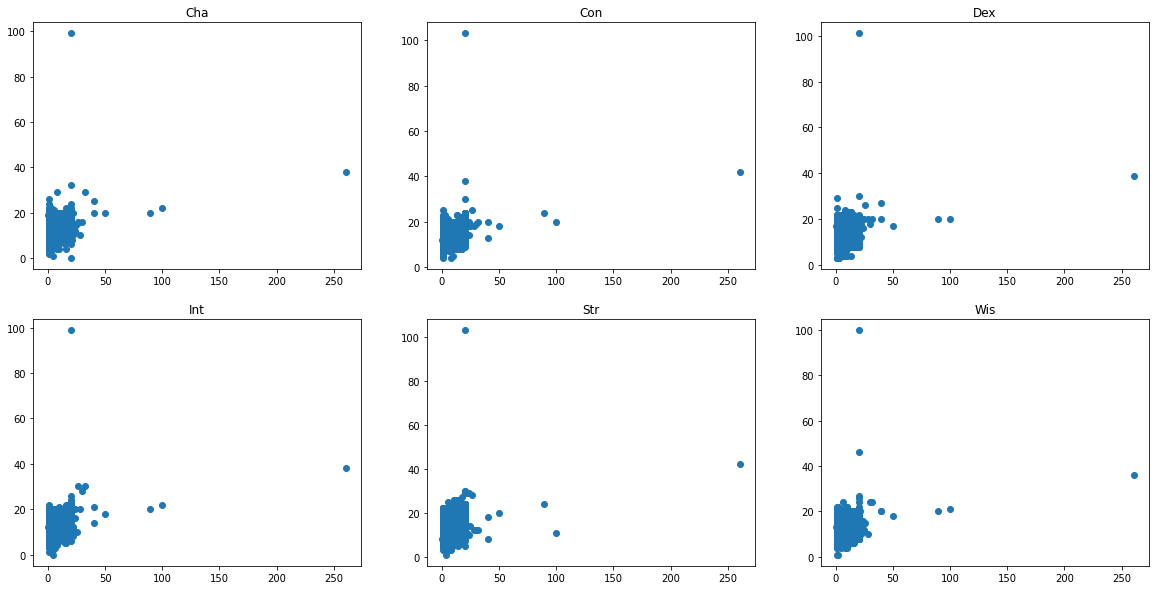

In [ ]:
# get attribute data
attributes_data = json_normalize(df['attributes'])

# convert into numbers 
#attributes_data[cols] = attributes_data[cols].astype(str).replace({'\[':''}, regex=True)
#attributes_data[cols] = attributes_data[cols].astype(str).replace({'\]':''}, regex=True)
#attributes_data[cols] = attributes_data[cols].astype(int)
for attribute in attributes:
  attributes_data[attribute] = attributes_data[attribute].str[0] # works if type(attributes_data[col]) == list

print(attributes_data.describe())
      
if 0:
  for iattribute, attribute in enumerate(attributes):
    plt.hist(attributes_data[attribute], bins=50, range=(0,50))
    plt.xlabel(attribute)
    plt.yscale('log')
    plt.show()

    for iattribute2, attribute2 in enumerate(attributes):
      if iattribute2 > iattribute:
        plt.hist2d(attributes_data[attribute], attributes_data[attribute2], bins=50, range=[(0,50),(0,50)])
        plt.xlabel(attribute)
        plt.ylabel(attribute2)
        plt.show()    

att_dfs = []
for att in attributes:
  att_dfs.append(clean_df[att] / clean_df['level'])



zzz = plt.boxplot(att_dfs, labels=attributes)
plt.show()

fig, axs = plt.subplots(2,3, figsize=(20, 10))

derp = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
for iatt, att in enumerate(attributes):
  axs[derp[iatt][0], derp[iatt][1]].scatter(clean_df['level'], clean_df[att])
  axs[derp[iatt][0], derp[iatt][1]].set_title(att)
plt.show()


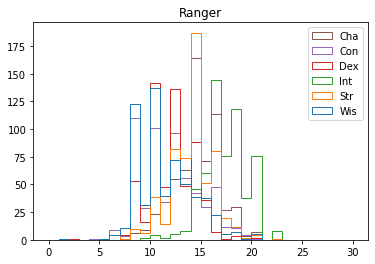

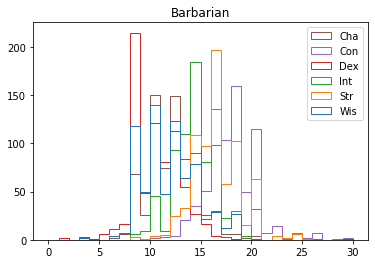

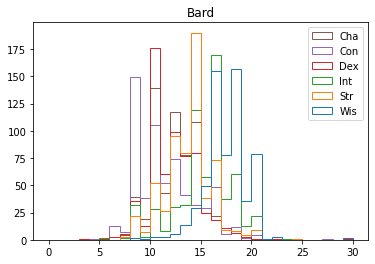

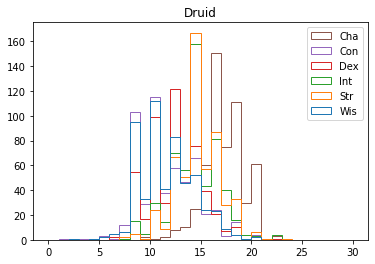

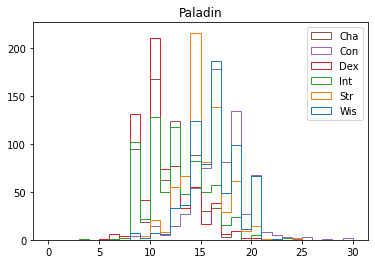

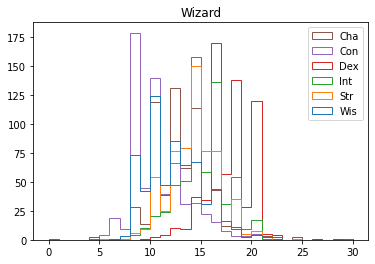

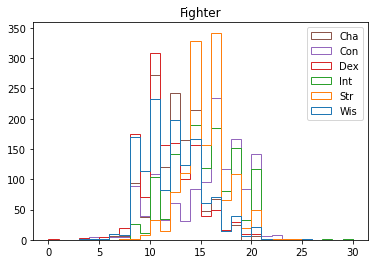

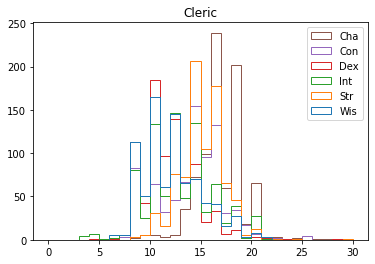

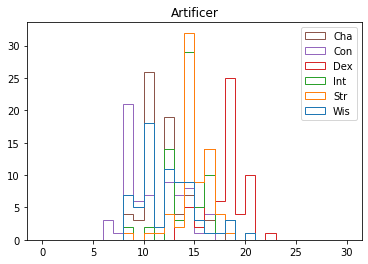

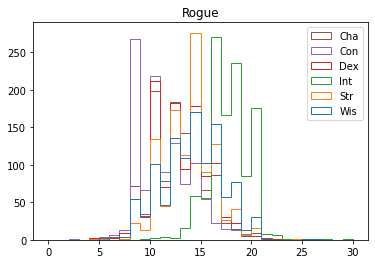

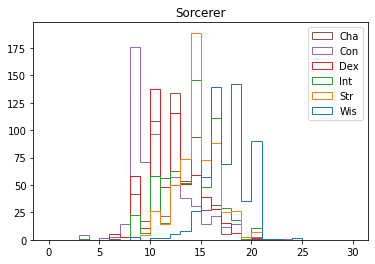

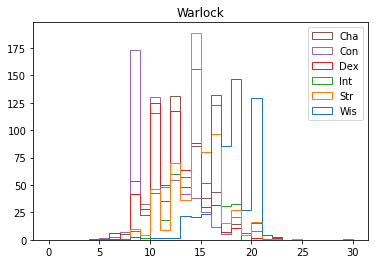

In [ ]:
for cls in class_levels:
  cls_df = clean_df[clean_df[cls].notnull()]
  atts = []
  for att in attributes:
    atts.append(cls_df[att])
  plt.hist(atts, histtype='step', fill=False, bins=30, range=(0,30))
  plt.legend(attributes)
  plt.title(cls.split('.')[0])
  plt.show()

### HP distributions

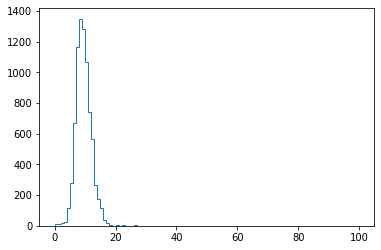

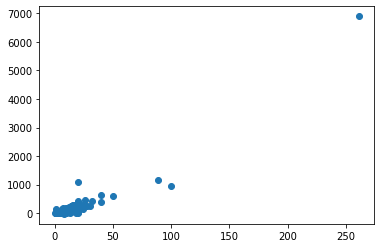

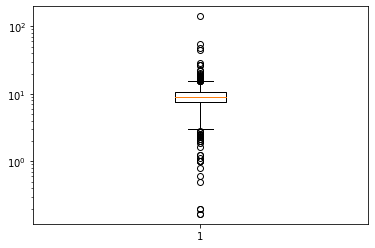

[array([7.6, 3. ]), array([10.75      , 15.46666667])]
98


In [ ]:
#plt.hist(clean_df['HP'], histtype='step', fill=False, bins=100, range=(0,1000))
#plt.show()


hp_per_level = clean_df['HP'].divide(clean_df['level'])

plt.hist(hp_per_level[hp_per_level <150], histtype='step', fill=False, bins=100, range=(0,100))
plt.show()

plt.scatter(clean_df['level'], clean_df['HP'])
plt.show()

zzz = plt.boxplot(hp_per_level[hp_per_level <150])
plt.yscale('log')
plt.show()
x = [item.get_ydata() for item in zzz['whiskers']]
print(x)
print(len(hp_per_level[hp_per_level >15]))

# for each class

#for cls in class_levels:
#  cls_df = clean_df[clean_df[cls].notnull()]
#  plt.hist(cls_df['HP'], histtype='step', fill=False, bins=50, range=(0,1000))
#  plt.title(cls.split('.')[0])
#  plt.show()

### AC distributions

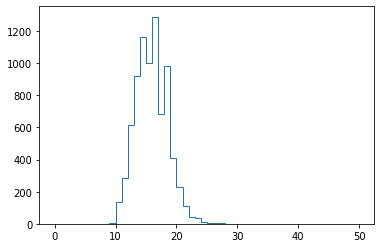

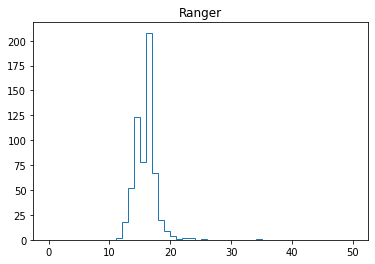

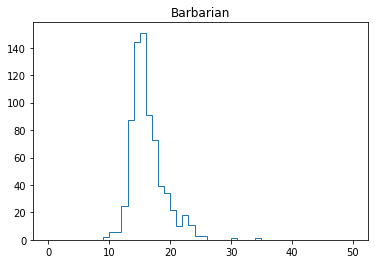

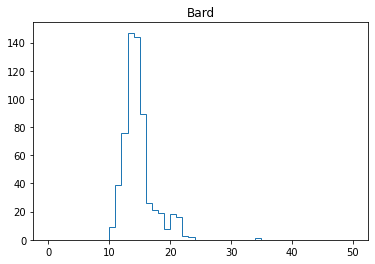

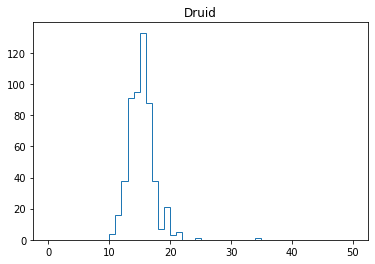

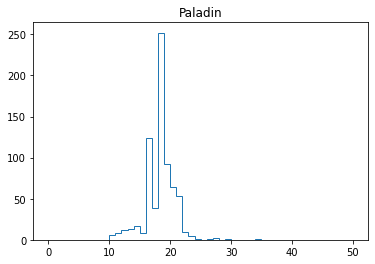

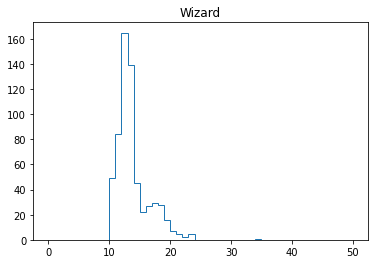

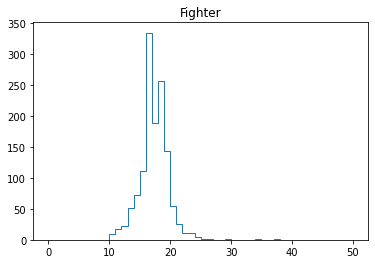

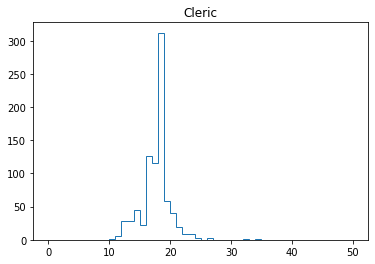

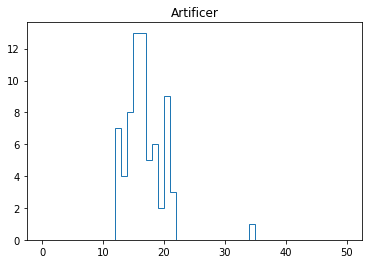

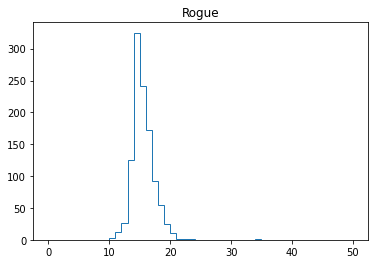

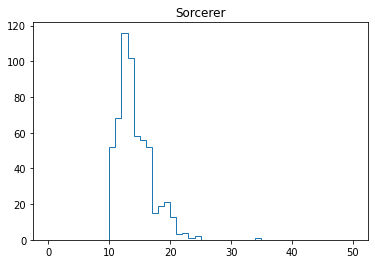

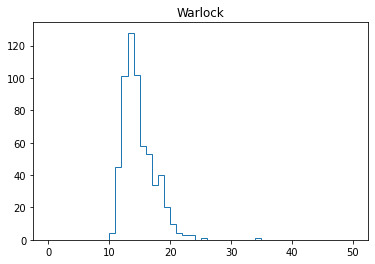

In [ ]:
plt.hist(clean_df['AC'], histtype='step', fill=False, bins=50, range=(0,50))
plt.show()

# for each class
for cls in class_levels:
  cls_df = clean_df[clean_df[cls].notnull()]
  plt.hist(cls_df['AC'], histtype='step', fill=False, bins=50, range=(0,50))
  plt.title(cls.split('.')[0])
  plt.show()

### Alignment distributions

count     7932
unique      10
top           
freq      5435
Name: processedAlignment, dtype: object
['' 'CN' 'CG' 'NN' 'NG' 'LE' 'LN' 'NE' 'LG' 'CE']


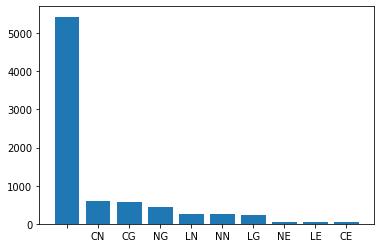

In [ ]:
# get alignment data
alignment_data = pd.json_normalize(df['alignment'])
#alignment_data = alignment_data['processedAlignment'].astype(str)
alignment_data = alignment_data['processedAlignment'].str[0]
alignment_data

print(alignment_data.describe())
print(alignment_data.unique())

#plt.hist(alignment_data, bins=10)
counts = alignment_data.value_counts()
plt.bar(counts.index, counts.values)
plt.show()


## Outlier Exploration

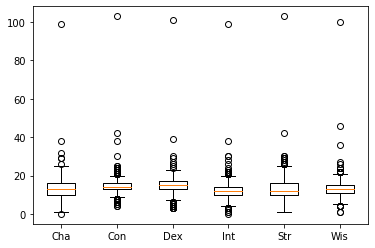

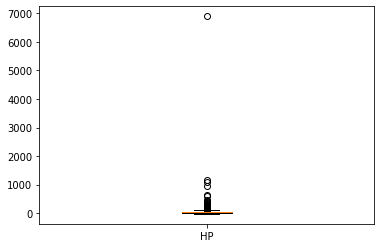

[-24.0, 114.0]


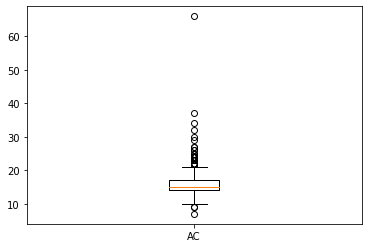

[10.0, 21.0]


In [ ]:
# descriptive statistics

clean_df[ ['Str','Dex','Con','Int','Wis','Cha'] ].describe()


# distributions

# IQR / boxplot outlier analysis
att_dfs = []
for att in attributes:
  att_dfs.append(clean_df[att])

plt.boxplot(att_dfs, labels=attributes)
plt.show()

for col in "HP", "AC":
  zzz = plt.boxplot(clean_df[col], labels=[col])
  plt.show()
  x = [item.get_ydata()[1] for item in zzz['whiskers']]
  print(x)
# remove outliers

## Correlations and Relationships

**Attributes**

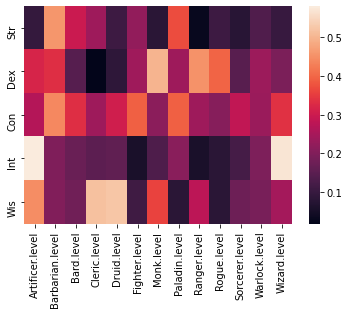

In [ ]:
# to identify which features we should include or may give us info

#plt.figure(figsize=(10,5))

# correlation between different attributes
#sns.heatmap(attributes_data.corr())
# con and str seam to have a decent correlation, but the rest dont


# correlation between attributes and classes
att_class_cols = ['Str','Dex','Con','Int','Wis','Cha','Artificer.level','Barbarian.level','Bard.level','Cleric.level','Druid.level','Fighter.level','Monk.level' \
                  ,'Paladin.level','Ranger.level','Rogue.level','Sorcerer.level','Warlock.level','Wizard.level']
att_class_df = clean_df[ att_class_cols ]

#sns.heatmap(att_class_df.corr())

att_class_corr = att_class_df.corr()
att_class_corr = att_class_corr.iloc[ 0:5, 6:]
sns.heatmap(att_class_corr)

#print(pd.plotting.scatter_matrix(att_class_df, figsize = (20,15)))
# correlation is probably not the way to go, since this is multiclass...maybe probability / likelihood?




**Casting Stat**

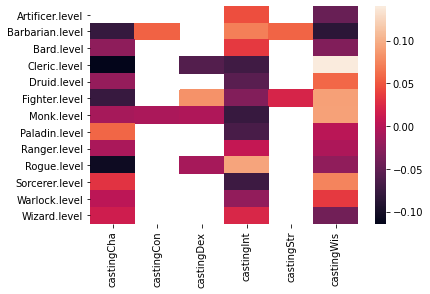

In [ ]:

# correlation between alignment and classes

casting_stat = ['castingCha', 'castingCon', 'castingDex', 'castingInt', 'castingStr', 'castingWis']

cast_stat_class_df = clean_df[class_list + casting_stat]
sns.heatmap(cast_stat_class_df.corr().iloc[0:13, 13:])



**Armor Class**

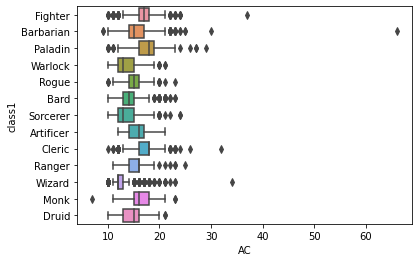

In [ ]:

# let's look at armor class
ac_df = clean_df[['AC','class1']]

ax = sns.boxplot(x="AC", y="class1", data=ac_df)


# Model Planning

In [ ]:
# what will success look like
 # define the set to which your model can be applied (aka single class characters)
 # build models optimizing for both acc and f1 score--how do they compare?

 # Success would look like: Can correctly identify class of single class character with 80% TPR, and <5% FPR

# what will our accuracy metrics be?
  # TPR, FPR, PPV

# Building a model:
  # Pick what algorithm we want to use
  # determine any issues / concerns associated with the model, things we should watch out for
  # split our data into test/train
  # train the model using k fold cross validation
    # all on training set
  # look at accuracy metrics (i.e. tpr/fpr, confusion matrix, recall, precision)
    # all needs to be done on the test set
  # investigate model behavior -- taking a deeper look
  


# Logistic Regression

## Binary Logistic Regression

In [ ]:
# LR is binary classifier, so what can we do?
# we can do 1vsAll (will lead to class imbalance)
# could only build model on 2 classes in data
# we could generalize classes to spellcasters/not spell casters (1/0)

# to do this, need a new is_spellcaster column
# Bard, Druid, Wizard, Cleric, Sorcerer, Warlock
spellcasters = ['Bard','Cleric','Druid','Sorcerer','Warlock','Wizard']

# create spellcaster class column
main_df['is_spellcaster'] = main_df['class1'].isin(spellcasters).astype(int)

# check for imbalance -- spoiler, doesn't look bad
main_df.groupby('is_spellcaster').count()

#split the data
# first split the features out from the class 
# oops, forgot to make hp/level
main_df['hp_per_lvl'] = main_df['HP'] / main_df['level1']

features = ['AC',
            'Str','Dex','Con','Int','Wis','Cha',
            'castingStr','castingDex','castingCon','castingInt','castingWis','castingCha',
            'hp_per_lvl']
X = main_df[ features ]
y = main_df['is_spellcaster']

# actually split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# check balance again between training and test set
print(y_train.groupby(y_train).size()) # dunno why it works like this for pd.Series, but it does
print(y_test.groupby(y_test).size())

# build the classifier
# logistic regression no CV
clf = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ', clf.score(X_test, y_test))
# ACC no cv on training set = 0.89609, testing 0.898929

is_spellcaster
0    2925
1    2193
Name: is_spellcaster, dtype: int64
is_spellcaster
0    924
1    782
Name: is_spellcaster, dtype: int64
training accuracy  0.8958577569363032
testing accuracy  0.8933177022274326


In [ ]:
# logistic regression with CV
clf = LogisticRegressionCV(cv = 10, random_state=42, solver='liblinear').fit(X_train, y_train)
print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ',clf.score(X_test, y_test))

# use f1 scoring
clf = LogisticRegressionCV(cv = 10, random_state=42, solver='liblinear', scoring = 'f1').fit(X_train, y_train)
print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ',clf.score(X_test, y_test))

# ACC with cv 0.89609 training, with cv testing 0898929
# ACC with cv and f1 score 0.88513

y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print('recall score: ', metrics.recall_score(y_test, y_pred))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)
# fpr = fp / (fp + tn)
print('tpr: ', tp / (tp+fn))
print('fpr: ', fp / (fp+tn))

# TPR is good at > 80%, but FPR is 8.7%, we wanted < 5%

training accuracy  0.8983978116451738
testing accuracy  0.8874560375146542
training accuracy  0.8821396192203084
testing accuracy  0.8764478764478765
[[833  91]
 [101 681]]
recall score:  0.870843989769821
tpr:  0.870843989769821
fpr:  0.09848484848484848


[[0.3573627  0.6426373 ]
 [0.99884471 0.00115529]
 [0.98934569 0.01065431]
 ...
 [0.04311813 0.95688187]
 [0.97993142 0.02006858]
 [0.72342991 0.27657009]]
[0.6426373  0.00115529 0.01065431 ... 0.95688187 0.02006858 0.27657009]


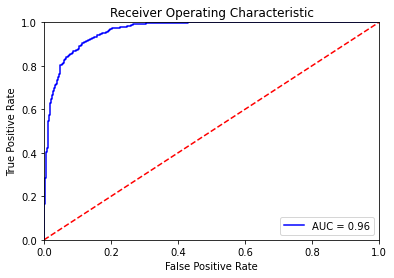

In [ ]:
# generate a ROC curve to see if we can change decision boundary to enhance results
# calculate the fpr and tpr for all thresholds of the classification

# probabilities of being in each class
probs = clf.predict_proba(X_test)
print(probs)

# extract probability observation is class 1
preds = probs[:,1]
print(preds)

# 3 arrays with fpr, tpr, threshold for given thresholds
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# list( zip( threshold, fpr, tpr ) )
# looks like we can ALMOST get to our goal with the following threshold,fpr,tpr
# 0.703401700557358, 0.04898828541001065, 0.7940780619111709



## Multi-class Logistic Regression

In [ ]:
# TODO
# change y to multiclass class1
y = main_df['class1']

# actually split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# build the classifier
# logistic regression no CV
clf = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto').fit(X_train, y_train)

print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ', clf.score(X_test, y_test))
# ACC no cv on training set = 0.89609, testing 0.898929

# Accuracy measurements
y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))


# generate a ROC curve to see if we can change decision boundary to enhance results
# calculate the fpr and tpr for all thresholds of the classification

# probabilities of being in each class
probs = clf.predict_proba(X_test)
print(probs)

# extract probability observation is class 1
preds = probs[:,1]
print(preds)






training accuracy  0.7370066432200079
testing accuracy  0.7250879249706916
[[ 83   0   0   0  31   0   0   0   1   0   0   2]
 [  0  78   0   0   0   0   6   0   0  34   7   0]
 [  0   0 154  29   0   0   0   7   0   0   0   0]
 [  0   0  21  78   0   0   0  16   0   0   0   0]
 [ 33   0   0   0 150  14   3   1  34   0   0   2]
 [  4   0   2   2   7  89   0   2  17   0   0   1]
 [  0   6   0   0   0   0 112   0   0   1   2   1]
 [  0   0   4   8   0   0   0 115   0   0   0   0]
 [  2   2   0   0  13  14   0   1 157   0   0   8]
 [  0  21   0   0   0   0   5   0   0  77   3   0]
 [  0  39   0   1   0   0   4   0   0  41  23   2]
 [  0   0   0   0   4   0   0   0  11   0   0 121]]
              precision    recall  f1-score   support

   Barbarian      0.680     0.709     0.695       117
        Bard      0.534     0.624     0.576       125
      Cleric      0.851     0.811     0.830       190
       Druid      0.661     0.678     0.670       115
     Fighter      0.732     0.633     0.6

# Decision Tree

## Binary Decision Tree

In [ ]:
# let's check out decision tree
# can handle multiple classes
# risks: overfitting, offset with hyperparameters

# use same training / testing data
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf= 20)
clf = clf.fit(X_train, y_train)

print('training ACC', clf.score(X_train, y_train))
print('testing ACC', clf.score(X_test, y_test))

training ACC 0.7704181320828448
testing ACC 0.7286049237983587


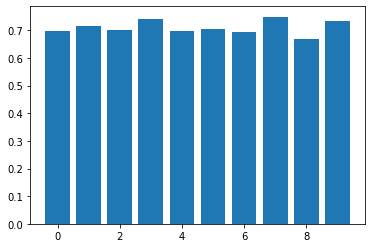

mean f1 score of 10-fold cv: 0.710, (std: 0.023)


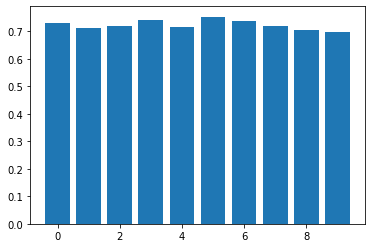

mean f1 score of 10-fold cv: 0.724, (std: 0.016)


In [ ]:
# https://scikit-learn.org/stable/modules/grid_search.html#model-specific-cross-validation
# DT doesn't have a dedicated CV function like LogisticRegressionCV

# perform 10-fold cv and print the f1 score for each fold
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf= 20)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

if 0: # this takes awhile to run, change to 1 if you want to play with it
  # hyperparameter tuning with grid search
  param_grid = {"criterion": ['gini', 'entropy'],
                "max_depth": [None, 5, 10, 20],
                "min_samples_leaf": [1, 5, 10, 20],
                "min_samples_split": [2, 5, 10, 20]
                }

  dt = tree.DecisionTreeClassifier()

  grid_search = GridSearchCV(dt, param_grid=param_grid, cv=10, scoring='f1')
  grid_search.fit(X_train, y_train)
  print('Best parameters: ', grid_search.best_params_)
  print('Resulting best score:', grid_search.best_score_)
  # result: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}

# perform 10-fold cv and print the f1 score for each fold using optimized hyperparameters
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf= 5, min_samples_split=10)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

In [ ]:
# look at confusion matrix and tpr/fpr for DT
# cross_val_{predict, score} do the fitting on the fly
# this means doing the rest with a single DT, no cv

clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf= 5, min_samples_split=10)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))
print('recall score: ', metrics.recall_score(y_test, y_pred))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

print('tpr: ', tp / (tp+fn))
print('fpr: ', fp / (fp+tn))

[[ 77   0   0   0  32   4   0   0   3   0   0   1]
 [  0  77   0   0   0   0   4   0   1   8  35   0]
 [  0   0 152  27   0   0   0  11   0   0   0   0]
 [  0   0  11  89   0   1   0  14   0   0   0   0]
 [ 22   0   0   0 174  14   3   2  21   0   0   1]
 [  4   1   0   2   8  93   0   0  15   0   0   1]
 [  0   5   0   0   0   0 108   0   0   4   4   1]
 [  0   0   3  25   0   1   0  98   0   0   0   0]
 [  1   2   1   0  16   6   0   0 160   0   0  11]
 [  0  25   0   0   0   0   4   0   0  60  17   0]
 [  0  35   0   1   0   0   2   0   0  20  50   2]
 [  0   0   0   0   3   3   0   0  12   0   0 118]]


ValueError: ignored

In [ ]:
# use a single decision tree to calculate probabilities

probs = clf.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

list(zip(threshold, fpr, tpr))
# definitely satisfy the tpr > 80%, fpr < 5% success metric for a range of thresholds
# specific threshold depends on if you want to prioritize cranking up tpr or suppressing fpr

## Multi-class Decision Tree

In [ ]:
# new target column using the entire multiclass 
X = main_df[ features ]
y = main_df['class1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(y_train.groupby(y_train).size())
print(y_test.groupby(y_test).size())



In [ ]:
# not sure if f1_macro is the right f1 score to use here
# https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult
# https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf= 20)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

if 1: # this takes awhile to run, change to 1 if you want to play with it
  # hyperparameter tuning with grid search
  param_grid = {"criterion": ['gini', 'entropy'],
                "max_depth": [None, 5, 10, 20],
                "min_samples_leaf": [1, 5, 10, 20],
                "min_samples_split": [2, 5, 10, 20]
                }

  dt = tree.DecisionTreeClassifier()

  grid_search = GridSearchCV(dt, param_grid=param_grid, cv=10, scoring='f1_macro')
  grid_search.fit(X_train, y_train)
  print('Best parameters: ', grid_search.best_params_)
  print('Resulting best score:', grid_search.best_score_)
 
# perform 10-fold cv and print the f1 score for each fold using optimized hyperparameters
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf= 1, min_samples_split=2)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf= 1, min_samples_split=2)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))





###Feature Importance

In [ ]:
# feature importance for multiclass decision tree

importance = clf.feature_importances_

# combine list of features and importance weights into dataframe
importance_dt = zip(list(X_train.columns), importance)
importance_dt = set(importance_dt)
importance_dt = pd.DataFrame(importance_dt, columns = ['feature','importance'])

# sort dataframe to graph from high to low
importance_dt = importance_dt.sort_values('importance',ascending = True)
importance_dt.reset_index(drop = True)
#importance_dt.sort_index()

# plot the feature weights
plt.figure()
plt.title("Feature importances: Multi Class DT")
plt.barh(range(importance_dt.shape[0]), width = importance_dt['importance'], align="center")
plt.yticks(range(importance_dt.shape[0]), importance_dt['feature'])
plt.ylim([-1, importance_dt.shape[0]])
plt.show()

# Support Vector Machine

## Linear SVM

In [ ]:
# bring in some libraries to do scaling and svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.svm import SVC

# create classifier by first scaling the data (mean 0 sd 1) and then putting into linear SVM
# SVM does better if features are scaled as it is not scale invariant
clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

## Grid Search on SVM

In [ ]:
# let's scale the data since it doesn't like the pipeline in grid search
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)



In [ ]:
# lets do a grid search instead of going through all different kernels, etc.

if 1: # this takes awhile to run, change to 1 if you want to play with it
  # hyperparameter tuning with grid search
  param_grid = {"kernel": ['linear', 'rbf','poly','sigmoid'],
                "degree": [2,3,4],
                "decision_function_shape": ['ovr','ovo']
                
                }

  clf = SVC()

  grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='f1_macro')
  grid_search.fit(X_train_scaled, y_train)
  print('Best parameters: ', grid_search.best_params_)
  print('Resulting best score:', grid_search.best_score_)

In [ ]:
# now let's build with those parameters
clf = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', degree = 2, decision_function_shape = 'ovr'))
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

#XGBoost

In [ ]:
# to really understand this we will need to study gradient descent

import xgboost

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_encoded = label_encoder.transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[[ 87   0   0   0  27   0   0   0   1   0   0   2]
 [  0  87   0   0   0   0   3   0   0  20  15   0]
 [  0   0 165  22   0   0   0   3   0   0   0   0]
 [  0   0   9  91   0   2   0  13   0   0   0   0]
 [ 29   0   0   0 170  10   3   1  24   0   0   0]
 [  5   0   0   2   6  92   0   1  17   0   0   1]
 [  0   2   0   0   0   0 118   0   0   0   1   1]
 [  0   0   2   6   0   1   0 118   0   0   0   0]
 [  1   1   0   1  13  11   0   0 163   0   0   7]
 [  0  15   0   0   0   0   2   0   0  76  13   0]
 [  0  26   0   0   0

           count       mean        std  min  25%  50%   75%   max
class1                                                           
Barbarian  570.0   0.161404   0.651011  0.0  0.0  0.0   0.0   3.0
Bard       474.0   4.037975   5.634257  0.0  0.0  0.0   8.0  31.0
Cleric     680.0  10.398529  10.295272  0.0  4.0  8.0  13.0  94.0
Druid      476.0   5.161765   8.150498  0.0  0.0  2.0   8.0  98.0
Fighter    942.0   0.615711   1.901084  0.0  0.0  0.0   0.0  15.0
Monk       499.0   0.202405   0.817181  0.0  0.0  0.0   0.0   6.0
Paladin    571.0   3.945709   4.253650  0.0  0.0  4.0   6.0  27.0
Ranger     490.0   1.793878   2.447895  0.0  0.0  0.0   3.0  15.0
Rogue      777.0   0.548263   1.794335  0.0  0.0  0.0   0.0  12.0
Sorcerer   436.0   5.215596   5.489328  0.0  0.0  5.0   9.0  24.0
Warlock    404.0   5.700495   7.179852  0.0  0.0  4.0   9.0  53.0
Wizard     505.0   8.172277  10.268616  0.0  0.0  5.0  13.0  56.0
           count      mean       std  min       25%       50%       75%   ma

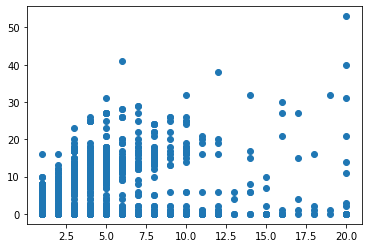

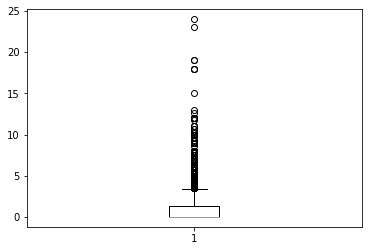

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[[ 87   0   0   0  27   0   0   0   1   0   0   2]
 [  0  87   0   0   0   0   3   0   0  20  15   0]
 [  0   0 165  22   0   0   0   3   0   0   0   0]
 [  0   0   9  91   0   2   0  13   0   0   0   0]
 [ 29   0   0   0 170  10   3   1  24   0   0   0]
 [  5   0   0   2   6  92   0   1  17   0   0   1]
 [  0   2   0   0   0   0 118   0   0   0   1   1]
 [  0   0   2   6   0   1   0 118   0   0   0   0]
 [  1   1   0   1  13  11   0   0 163   0   0   7]
 [  0  15   0   0   0   0   2   0   0  76  13   0]
 [  0  26   0   0   0

In [ ]:
# xgboost doesn't improve upon DT, despite being a slightly more refined approach
# might be running into a 'wall' of what information can be extracted from these features and they are not discriminative
# enough to distinguish Bard, Warlock, and Sorcerer
#
main_df.groupby('class1')['spells'].describe()

spells_per_level = main_df['spells'].divide(main_df['level'])
main_df['spells_per_lvl'] = spells_per_level

print(main_df.groupby('class1')['spells'].describe())

print(main_df.groupby('class1')['spells_per_lvl'].describe())

spellcasters_df = clean_df[clean_df['class1'].isin(['Bard', 'Warlock', 'Sorcerer'])]

plt.scatter(spellcasters_df['level1'], spellcasters_df['spells'])
plt.show()

plt.boxplot(main_df['spells_per_lvl'])
plt.show()

features = ['AC',
            'Str','Dex','Con','Int','Wis','Cha',
            'castingStr','castingDex','castingCon','castingInt','castingWis','castingCha',
            'hp_per_lvl', 'spells_per_lvl']
X = main_df[ features ]

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))
#plt.hist(main_df['spells'], histtype='step', fill=False, bins=40, range=(0,40))
#plt.show()




# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

[[ 91   0   0   0  22   1   0   0   2   0   0   1]
 [  0 102   0   0   0   0   3   0   0   7  13   0]
 [  0   0 177  11   0   0   0   2   0   0   0   0]
 [  0   0   5  99   0   1   0  10   0   0   0   0]
 [ 28   0   0   0 180   8   2   0  18   0   0   1]
 [  4   0   0   2   5  95   0   0  18   0   0   0]
 [  0   2   0   0   0   0 118   0   0   0   1   1]
 [  0   0   2   8   0   0   0 117   0   0   0   0]
 [  1   1   0   0   9  11   0   0 170   0   0   5]
 [  0  10   0   0   0   0   4   0   0  77  15   0]
 [  0  24   0   1   0   0   3   0   0  13  67   2]
 [  0   0   0   0   1   0   0   0  10   0   0 125]]
              precision    recall  f1-score   support

   Barbarian      0.734     0.778     0.755       117
        Bard      0.734     0.816     0.773       125
      Cleric      0.962     0.932     0.947       190
       Druid      0.818     0.861     0.839       115
     Fighter      0.829     0.759     0.793       237
        Monk      0.819     0.766     0.792       124
     Pal

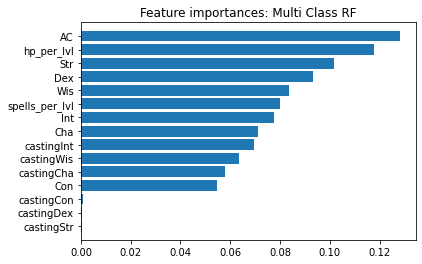

In [ ]:
# feature importance for multiclass Random Forest

importance = clf.feature_importances_

# combine list of features and importance weights into dataframe
importance_dt = zip(list(X_train.columns), importance)
importance_dt = set(importance_dt)
importance_dt = pd.DataFrame(importance_dt, columns = ['feature','importance'])

# sort dataframe to graph from high to low
importance_dt = importance_dt.sort_values('importance',ascending = True)
importance_dt.reset_index(drop = True)
#importance_dt.sort_index()

# plot the feature weights
plt.figure()
plt.title("Feature importances: Multi Class RF")
plt.barh(range(importance_dt.shape[0]), width = importance_dt['importance'], align="center")
plt.yticks(range(importance_dt.shape[0]), importance_dt['feature'])
plt.ylim([-1, importance_dt.shape[0]])
plt.show()